In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
generator = torch.Generator().manual_seed(seed)  # For random_split

In [3]:
data_dir = "FINAL_TRAINING_DATA"

In [4]:
def calculate_mean_std(data_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor() 
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    mean = np.zeros(3)  # For R, G, B
    std = np.zeros(3)
    n_pixels = 0

    for img, _ in dataset:
        img = img.numpy()  # Shape: [3, H, W]
        mean += img.mean(axis=(1, 2))  # Mean per channel
        std += img.std(axis=(1, 2))  # Std per channel
        n_pixels += img.shape[1] * img.shape[2]  # Total pixels per image

    # Average over all images
    mean /= len(dataset)
    std /= len(dataset)

    return mean, std

mean, std = calculate_mean_std(data_dir)
print(f"Mean (R,G,B): {mean}")
print(f"Std (R,G,B): {std}")

Mean (R,G,B): [0.31289829 0.22598431 0.1917622 ]
Std (R,G,B): [0.16561684 0.16385502 0.14464571]


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # this is original shape for MobileNet_v2
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # custom stats
])

In [6]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
class_names

['DROWSY_NOT', 'DROWSY_YES']

In [7]:
dataset.class_to_idx

{'DROWSY_NOT': 0, 'DROWSY_YES': 1}

In [8]:
# Split into train (70%), val (15%), test (15%)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

In [9]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [10]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# pretrained MobileNet_v3_small model
model = mobilenet_v3_small(weights=None)
model.to(device);

In [13]:
for name, layer in model.named_modules():
    print(name, '→', layer)

 → MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1

In [14]:
# this is our final layer to be replaced
model.classifier[3]

Linear(in_features=1024, out_features=1000, bias=True)

In [15]:
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)

In [16]:
# verify which parameters are trainable; just double checking
for name, param in model.named_parameters():
    print(f"{name:60}  trainable={param.requires_grad}")

features.0.0.weight                                           trainable=True
features.0.1.weight                                           trainable=True
features.0.1.bias                                             trainable=True
features.1.block.0.0.weight                                   trainable=True
features.1.block.0.1.weight                                   trainable=True
features.1.block.0.1.bias                                     trainable=True
features.1.block.1.fc1.weight                                 trainable=True
features.1.block.1.fc1.bias                                   trainable=True
features.1.block.1.fc2.weight                                 trainable=True
features.1.block.1.fc2.bias                                   trainable=True
features.1.block.2.0.weight                                   trainable=True
features.1.block.2.1.weight                                   trainable=True
features.1.block.2.1.bias                                     trainable=True

In [17]:
model.to(device);

In [18]:
criterion = nn.BCEWithLogitsLoss()  # BCE loss for binary classification
optimizer = optim.Adam(model.classifier[3].parameters(), lr=0.005)  # Optimize only the classifier head
num_epochs = 100

In [19]:
best_val_loss = float('inf')
patience = 15
counter = 0

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    train_loss /= len(train_loader)
    train_acc = correct / total

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1:02d}/{num_epochs}] "
          f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:6.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}%")

    # ---- EARLY STOPPING ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "MobileNet_224_Scratch.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

Epoch [01/100] | Train Loss: 0.6844 | Train Acc:  54.92% | Val Loss: 0.6980 | Val Acc:  46.72%
Epoch [02/100] | Train Loss: 0.6599 | Train Acc:  62.58% | Val Loss: 0.7054 | Val Acc:  46.72%
Epoch [03/100] | Train Loss: 0.6551 | Train Acc:  62.66% | Val Loss: 0.7042 | Val Acc:  46.72%
Epoch [04/100] | Train Loss: 0.6413 | Train Acc:  66.17% | Val Loss: 0.6886 | Val Acc:  48.91%
Epoch [05/100] | Train Loss: 0.6305 | Train Acc:  68.75% | Val Loss: 0.6267 | Val Acc:  69.34%
Epoch [06/100] | Train Loss: 0.6372 | Train Acc:  67.42% | Val Loss: 0.6041 | Val Acc:  67.52%
Epoch [07/100] | Train Loss: 0.6295 | Train Acc:  65.70% | Val Loss: 0.5907 | Val Acc:  67.88%
Epoch [08/100] | Train Loss: 0.6145 | Train Acc:  68.75% | Val Loss: 0.6073 | Val Acc:  70.80%
Epoch [09/100] | Train Loss: 0.6120 | Train Acc:  69.14% | Val Loss: 0.5763 | Val Acc:  68.25%
Epoch [10/100] | Train Loss: 0.6188 | Train Acc:  67.27% | Val Loss: 0.5654 | Val Acc:  73.36%
Epoch [11/100] | Train Loss: 0.6172 | Train Acc:  

# Evaluating Results

In [20]:
model.load_state_dict(torch.load("MobileNet_224_Scratch.pth"))  # load best model
model.to(device);

In [21]:
def get_predictions(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs.flatten())
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [22]:
test_labels, test_preds, test_probs = get_predictions(test_loader)

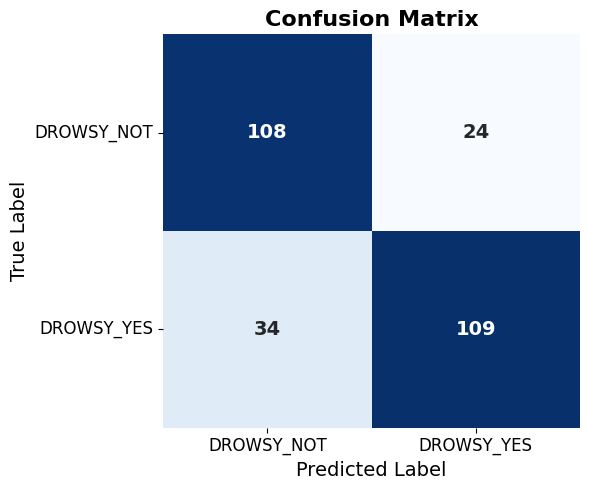

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14, "weight": "bold"})

plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

In [24]:
print(classification_report(test_labels, test_preds, target_names=class_names))

              precision    recall  f1-score   support

  DROWSY_NOT       0.76      0.82      0.79       132
  DROWSY_YES       0.82      0.76      0.79       143

    accuracy                           0.79       275
   macro avg       0.79      0.79      0.79       275
weighted avg       0.79      0.79      0.79       275



AUC-ROC: 0.8449


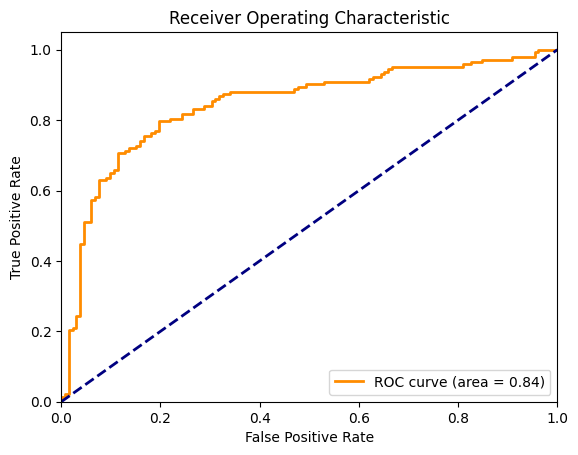

In [25]:
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")